In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [ ]:
pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 8.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, roc_auc_score
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import xgboost as xgb
import lightgbm as lgb

import shap
import eli5
from eli5.sklearn import PermutationImportance

from google.colab import drive

print("Les packages sont bien importés")
drive.mount("/content/drive")

! ls drive/MyDrive/Reviews.csvOk

df_train = pd.read_excel("drive/MyDrive/Projet_Transverse/train_classique.xlsx")
df_test = pd.read_excel("drive/MyDrive/Projet_Transverse/test_classique.xlsx")

pd.set_option('display.max_columns',None)

Les packages sont bien importés
Mounted at /content/drive
ls: cannot access 'drive/MyDrive/Reviews.csvOk': No such file or directory


In [ ]:
for col in ['prop_m_25', 'P21_LOG']:
    moyenne = df_train[col].mean()
    df_train[col] = df_train[col].fillna(moyenne)

#Partie 3.1.1 - Optimisation stochastique

## Préparation des données

In [ ]:
col_a_enlever = ["Score","Score_norm","com","Score_norm_reel","Score_bin","Score_multi","taux_tues","taux_indemne","taux_hospitalise","taux_blesses_legerement"]

X_train = df_train.drop(columns=col_a_enlever)
X_test = df_test.drop(columns=col_a_enlever)

y_train = df_train["Score_norm"]
y_test = df_test["Score_norm"]

## Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Régression linéaire par descente de gradient classique

MSE train début : 4.183
MSE train final : 1.295
MSE test début : 4.073
MSE test final : 1.240


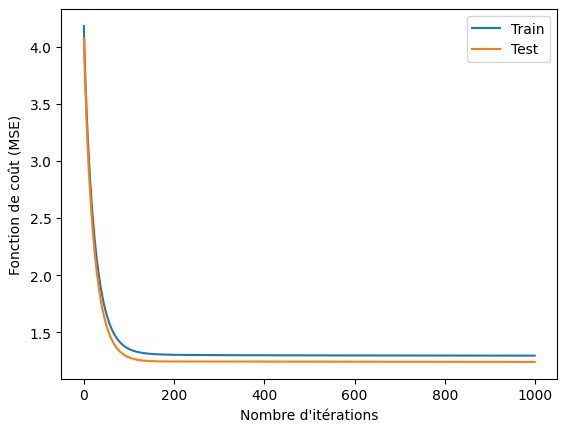

In [ ]:
taux_app = 0.02
n_iter = 1000
theta_init = np.zeros(X_train.shape[1])

theta = theta_init
cost_train_history = []
cost_test_history = []

for i in range(n_iter):
    gradients = (1 / len(y_train)) * X_train.T.dot(X_train.dot(theta) - y_train)
    theta = theta - taux_app * gradients

    # Coût sur le train
    cost_train = fonction_cout(X_train, y_train, theta)
    cost_train_history.append(cost_train)

    # Coût sur le test (sans entraîner sur le test !)
    cost_test = fonction_cout(X_test, y_test, theta)
    cost_test_history.append(cost_test)

print("MSE train début : {:.3f}".format(cost_train_history[0]))
print("MSE train final : {:.3f}".format(cost_train_history[-1]))
print("MSE test début : {:.3f}".format(cost_test_history[0]))
print("MSE test final : {:.3f}".format(cost_test_history[-1]))

plt.plot(range(n_iter), cost_train_history, label='Train')
plt.plot(range(n_iter), cost_test_history, label='Test')
plt.xlabel("Nombre d'itérations")
plt.ylabel('Fonction de coût (MSE)')
plt.legend()
plt.show()


Arrêt anticipé à l’itération 235
MSE au début : 4.183
MSE final : 1.301


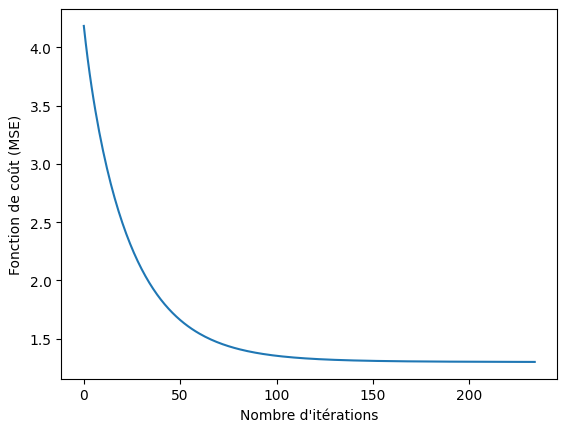

In [ ]:
# early stopping
def descente_classique_early(X, y, theta, taux_app, n_iterations,patience):
    m = len(y)
    best_cost = 100
    cost_history = []
    for i in range(n_iterations):
        gradients = (1 / m) * X.T.dot(X.dot(theta) - y)
        theta = theta - taux_app * gradients
        cost = fonction_cout(X, y, theta)
        cost_history.append(cost)
        if cost < best_cost - 0.005:  # tolérance d’amélioration
              best_cost = cost
              no_improve_count = 0
        else:
              no_improve_count += 1

        if no_improve_count >= patience:
              print(f"Arrêt anticipé à l’itération {i+1}")
              nb_iter_fi = i+1
              break
        nb_iter_fi = i+1
    return nb_iter_fi, theta, cost_history

patience = 50

nb_iter_fi, theta_gd, cost_gd = descente_classique_early(X_train, y_train, theta_init, taux_app, n_iter,patience)

print("MSE au début : {:.3f}".format(cost_gd[0]))
print("MSE final : {:.3f}".format(cost_gd[len(cost_gd)-1]))
plt.plot(range(nb_iter_fi), cost_gd)
plt.xlabel("Nombre d'itérations")
plt.ylabel('Fonction de coût (MSE)')
plt.show()

## Régression linéaire par descente de gradient stochastique

### Sans clipping

MSE au début : 4.344
MSE final : 1.413


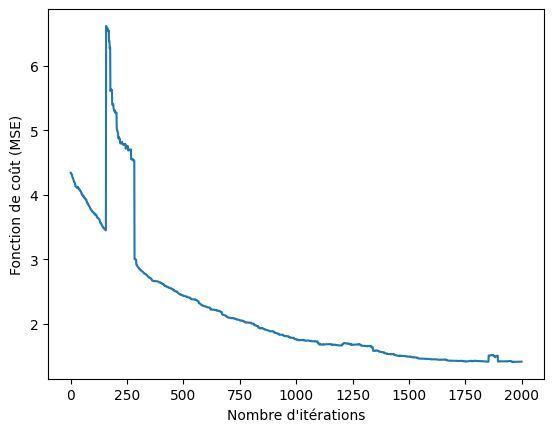

In [ ]:
col_a_enlever = ["Score","Score_norm","com","Score_norm_reel","Score_bin","Score_multi","taux_tues","taux_indemne","taux_hospitalise","taux_blesses_legerement"]

X_train = df_train.drop(columns=col_a_enlever)
X_test = df_test.drop(columns=col_a_enlever)

y_train = df_train["Score_norm"]
y_test = df_test["Score_norm"]

## Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_biais = np.c_[np.ones(X_train.shape[0]), X_train]
X_test_biais = np.c_[np.ones(X_test.shape[0]), X_test]

def descente_stochastique(X_train, y_train, learning_rate, num_iterations):
    theta = np.zeros(X_train.shape[1])
    cost_history = np.zeros(num_iterations)
    m = len(y_train)

    for i in range(num_iterations):
        random_index = np.random.randint(m)
        X_i = X_train[random_index, :]
        Y_i = y_train[random_index]
        error = np.dot(theta, X_i) - Y_i
        theta = theta - learning_rate * error * X_i
        cost_history[i] = fonction_cout(X_train,y_train,theta)

    return cost_history


learning_rate = 0.001
num_iterations = 2000

cost_history = descente_stochastique(X_train_biais, y_train, learning_rate, num_iterations)

print("MSE au début : {:.3f}".format(cost_history[0]))
print("MSE final : {:.3f}".format(cost_history[-1]))

import matplotlib.pyplot as plt

plt.plot(cost_history)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de coût (MSE)")
plt.show()

In [ ]:
print(np.max(X_train),np.min(X_train),np.mean(X_train),np.std(X_train))

72.68359600169182 -4.839565137796645 4.8862937156098074e-17 1.0


In [ ]:
import numpy as np

# X_train déjà normalisé
n_above = np.sum(X_train > 10)
n_below = np.sum(X_train < -10)
print(f"Nombre de valeurs aberrantes : {n_above + n_below}")

# On a quand même beaucoup de valeurs aberrantes dans notre DataFrame.

Nombre de valeurs aberrantes : 266


### Avec clipping

In [ ]:
# On voit que malgré la normalisation de nos données, il reste des valeurs très aberrantes. Avec le code ci-dessous, on limite les valeurs aberrantes à 10, ce qui stabilisera ainsi nos descentes de gradient, même si notre écart-type n'est plus à 1
# De plus, on va ensuite renormaliser notre dataframe plusieurs fois. Cela aura pour effet d'avoir des données normalisées, mais avec des valeurs aberrantes ayant un impact moindre

X_train = np.clip(X_train, -10, 50)
X_test = np.clip(X_test, -10, 50)

## Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print(np.max(X_train),np.min(X_train),np.mean(X_train),np.std(X_train))

60.07141202945425 -4.8395651377966455 -2.3002523910859292e-18 1.0


In [ ]:
X_train = np.clip(X_train, -10, 50)
X_test = np.clip(X_test, -10, 50)

## Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print(np.max(X_train),np.min(X_train),np.mean(X_train),np.std(X_train))

53.37258359862659 -4.8395651377966455 4.670209400083553e-18 1.0


In [ ]:
X_train = np.clip(X_train, -10, 30)
X_test = np.clip(X_test, -10, 30)

## Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print(np.max(X_train),np.min(X_train),np.mean(X_train),np.std(X_train))

38.701143387597206 -4.8395651377966455 -9.758646507637275e-19 1.0


In [ ]:
X_train = np.clip(X_train, -10, 20)
X_test = np.clip(X_test, -10, 20)

## Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print(np.max(X_train),np.min(X_train),np.mean(X_train),np.std(X_train))

29.580802915305085 -4.8395651377966455 1.254683122410507e-18 1.0000000000000002


MSE au début : 4.348
MSE final : 1.439


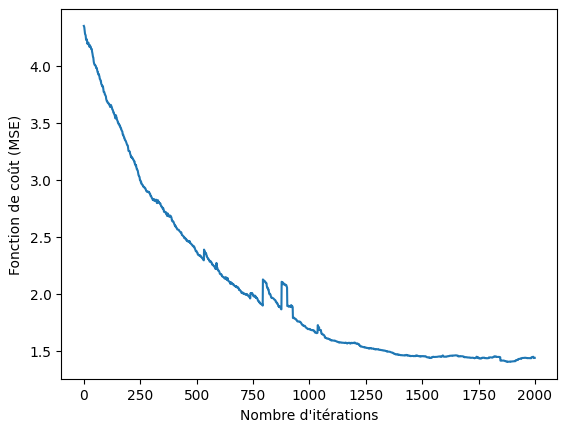

In [ ]:
X_train_biais = np.c_[np.ones(X_train.shape[0]), X_train]
X_test_biais = np.c_[np.ones(X_test.shape[0]), X_test]

def descente_stochastique(X_train, y_train, learning_rate, num_iterations):
    theta = np.zeros(X_train.shape[1])
    cost_history = np.zeros(num_iterations)
    m = len(y_train)

    for i in range(num_iterations):
        random_index = np.random.randint(m)
        X_i = X_train[random_index, :]
        Y_i = y_train[random_index]
        error = np.dot(theta, X_i) - Y_i
        theta = theta - learning_rate * error * X_i
        cost_history[i] = fonction_cout(X_train,y_train,theta)

    return cost_history


learning_rate = 0.001
num_iterations = 2000

cost_history = descente_stochastique(X_train_biais, y_train, learning_rate, num_iterations)

print("MSE au début : {:.3f}".format(cost_history[0]))
print("MSE final : {:.3f}".format(cost_history[-1]))

import matplotlib.pyplot as plt

plt.plot(cost_history)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de coût (MSE)")
plt.show()

Arrêt anticipé à l’itération 1097 (écart min-max < 0.01 sur les 50 dernières itérations)
MSE au début : 4.343
MSE final  : 1.725


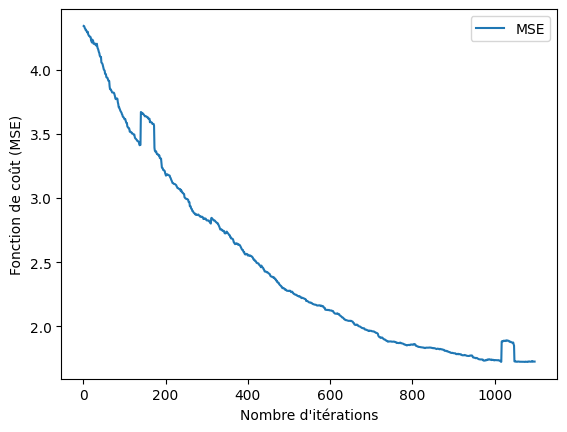

In [ ]:
def descente_sto_early_window(X, y, theta_init, learning_rate, n_iterations, patience, tolerance):
    """
    Descente de gradient stochastique avec early‐stopping basé sur l'écart min-max
    sur la fenêtre des `patience` dernières valeurs de coût.
    """
    theta = theta_init.copy()
    cost_history = []
    m = X.shape[0]

    for i in range(n_iterations):
        idx = np.random.randint(m)
        Xi, yi = X[idx], y[idx]
        error = np.dot(theta, Xi) - yi
        theta -= learning_rate * error * Xi

        cost = fonction_cout(X, y, theta)
        cost_history.append(cost)

        if len(cost_history) >= patience:
            window = cost_history[-patience:]
            if (max(window) - min(window)) < tolerance:
                print(f"Arrêt anticipé à l’itération {i+1} "
                      f"(écart min-max < {tolerance} sur les {patience} dernières itérations)")
                break

    return i+1, theta, cost_history

learning_rate = 0.001
n_iter        = 5000
patience      = 50
tolerance     = 0.01
theta_init    = np.zeros(X_train_biais.shape[1])

# Lancement
nb_iter_fi, theta_gd, cost_sgd = descente_sto_early_window(
    X_train_biais,
    y_train,
    theta_init,
    learning_rate,
    n_iter,
    patience,
    tolerance
)

print("MSE au début : {:.3f}".format(cost_sgd[0]))
print("MSE final  : {:.3f}".format(cost_sgd[-1]))

# Affichage de la courbe
import matplotlib.pyplot as plt

plt.plot(range(1, nb_iter_fi+1), cost_sgd, label='MSE')
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de coût (MSE)")
plt.legend()
plt.show()

## Descente de gradient stochastique via SGDClassifier

In [ ]:
col_a_enlever = ["Score","Score_norm","com","Score_norm_reel","Score_bin","Score_multi","taux_tues","taux_indemne","taux_hospitalise","taux_blesses_legerement"]

X_train = df_train.drop(columns=col_a_enlever)
X_test = df_test.drop(columns=col_a_enlever)

y_train = df_train["Score_norm"]
y_test = df_test["Score_norm"]

## Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# On a certaines valeurs manquantes, on les remplace par la moyenne
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_test)

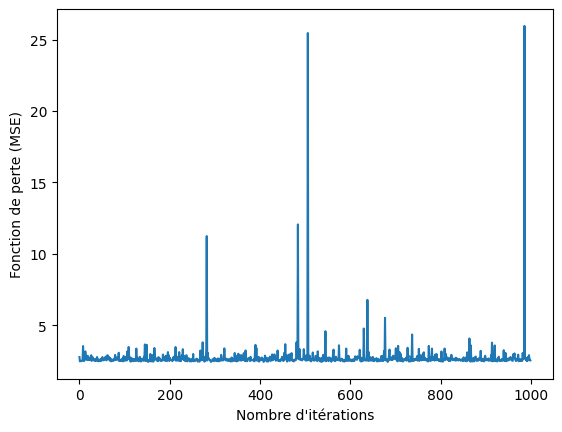

MSE sur les données de test : 2.530


In [ ]:
# On initialise le modèle avec la méthode de descente de gradient stochastique

model = SGDRegressor(max_iter=1000, tol=1e-2)

# On entraîne le modèle sur les données d'entraînement puis on prédit sur les données test

nb_iter = 1000

loss = []
for i in range(nb_iter):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    loss.append(mse)

# Afficher la fonction de coût en fonction du nombre d'itérations
plt.plot(range(nb_iter), loss)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de perte (MSE)")
plt.show()

# Voici des prédictions sur les données de test
print("MSE sur les données de test : {:.3f}".format(loss[len(loss)-1]))

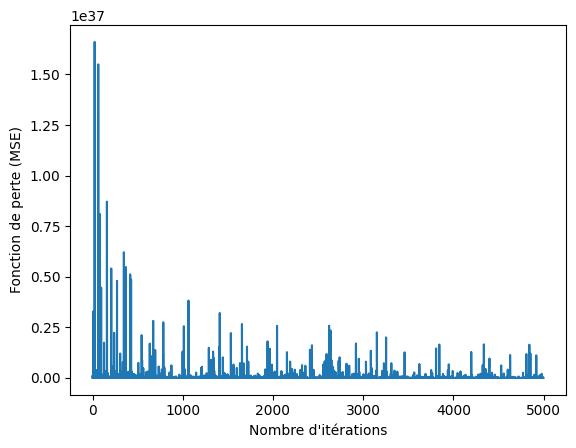

MSE sur les données de test : 2441707569589402982935521394688.000


In [ ]:
# On initialise le modèle avec la méthode de descente de gradient stochastique
model = SGDRegressor(max_iter=1000, tol=0.01)

# On entraîne le modèle sur les données d'entraînement puis on prédit sur les données test

nb_iter = 5000

loss = []
for i in range(nb_iter):
    model.partial_fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    loss.append(mse)

# Afficher la fonction de coût en fonction du nombre d'itérations
plt.plot(range(nb_iter), loss)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de perte (MSE)")
plt.show()

# Voici des prédictions sur les données de test
print("MSE sur les données de test : {:.3f}".format(loss[len(loss)-1]))

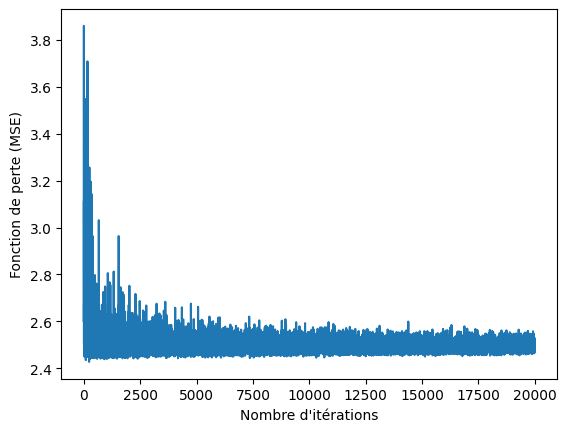

MSE sur les données de test : 2.471


In [ ]:
# On initialise le modèle avec la méthode de descente de gradient stochastique
model = SGDRegressor(max_iter=1000, tol=0.01)

# On entraîne le modèle sur les données d'entraînement puis on prédit sur les données test

nb_iter = 20000

loss = []
for i in range(nb_iter):
    model.partial_fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    loss.append(mse)

# Afficher la fonction de coût en fonction du nombre d'itérations
plt.plot(range(nb_iter), loss)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de perte (MSE)")
plt.show()

# Voici des prédictions sur les données de test
print("MSE sur les données de test : {:.3f}".format(loss[len(loss)-1]))

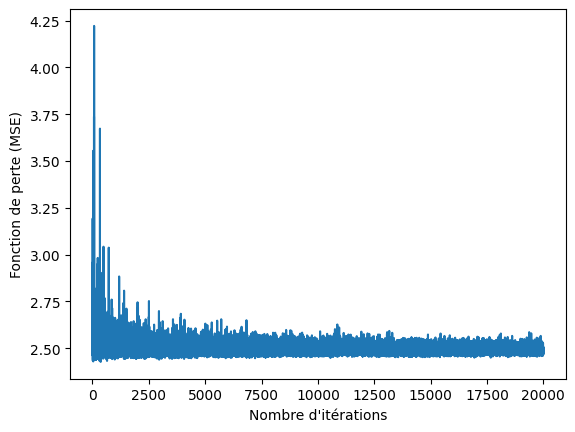

MSE final : 2.473


In [ ]:
model = SGDRegressor(max_iter=1000, tol=0.01, warm_start=True)

patience = 50
tolerance = 0.01  # seuil de tolérance sur l’écart min-max
loss = []

for i in range(nb_iter):
    model.partial_fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    loss.append(mse)

    if len(loss) >= patience:
        window = loss[-patience:]
        window_max = max(window)
        window_min = min(window)
        window_range = window_max - window_min

        if window_range < tolerance:
            print(f"Arrêt anticipé à l’itération {i+1} (écart min-max sur les {patience} dernières itérations < {tolerance})")
            break

# Affichage du graphique
plt.plot(range(1, len(loss) + 1), loss)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de perte (MSE)")
plt.show()

print("MSE final : {:.3f}".format(loss[-1]))


# Partie 3.1.2 - Partie Machine Learning

## Prédiction de la variable score_bin

In [ ]:
## Préparation des données

col_a_enlever = ["Score","Score_norm","com","Score_norm_reel","Score_bin","Score_multi","taux_tues","taux_indemne","taux_hospitalise","taux_blesses_legerement"]

X_train_bin = df_train.drop(columns=col_a_enlever)
X_test_bin = df_test.drop(columns=col_a_enlever)

y_train_bin = df_train["Score_bin"]
y_test_bin = df_test["Score_bin"]

# Normalisation
scaler = StandardScaler()
X_train_bin = scaler.fit_transform(X_train_bin)
X_test_bin = scaler.transform(X_test_bin)

# On a certaines valeurs manquantes, on les remplace par la moyenne
imputer = SimpleImputer(strategy='mean')
X_train_bin = imputer.fit_transform(X_train_bin)
X_test_bin = imputer.fit_transform(X_test_bin)

### Métriques pour l'évaluation des modèles

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    mse = mean_squared_error(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print(f"\n{model_name}")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"AUC : {auc:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Matrice de confusion - {model_name}")
    plt.show()

### Régression logistique


Régression logistique
Accuracy : 0.7157
F1-score : 0.7148
MSE : 0.2843
AUC : 0.7167


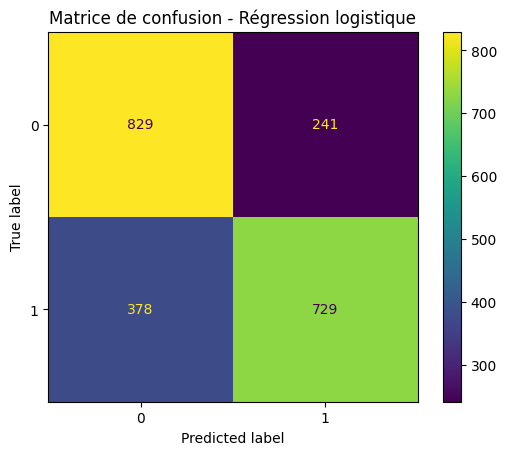

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_bin, y_train_bin)
evaluate_model(log_reg, X_test_bin, y_test_bin, "Régression logistique")


### KNN


KNN
Accuracy : 0.6128
F1-score : 0.6128
MSE : 0.3872
AUC : 0.6127


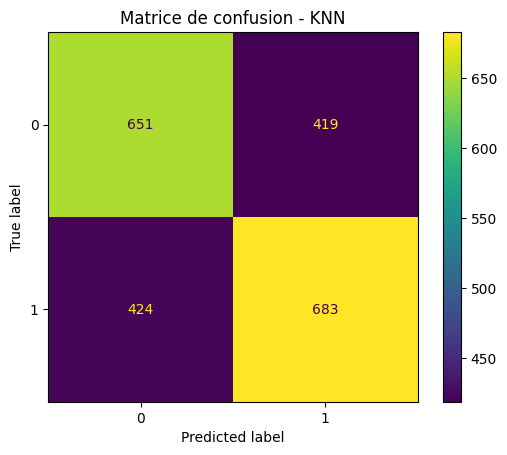

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_bin, y_train_bin)
evaluate_model(knn, X_test_bin, y_test_bin, "KNN")


### SVM

Linéaire


SVM Linéaire
Accuracy : 0.7092
F1-score : 0.7058
MSE : 0.2908
AUC : 0.7111


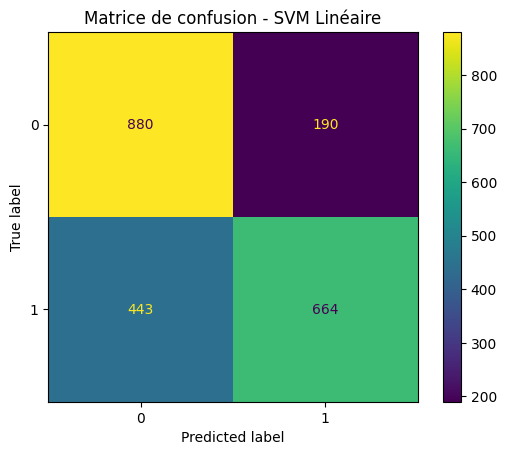

In [ ]:
# Probability = True sinon le calcul du Gini n'est pas automatique

svm_lin = SVC(kernel='linear', probability=True)
svm_lin.fit(X_train_bin, y_train_bin)
evaluate_model(svm_lin, X_test_bin, y_test_bin, "SVM Linéaire")


Radial


SVM RBF
Accuracy : 0.7083
F1-score : 0.7081
MSE : 0.2917
AUC : 0.7089


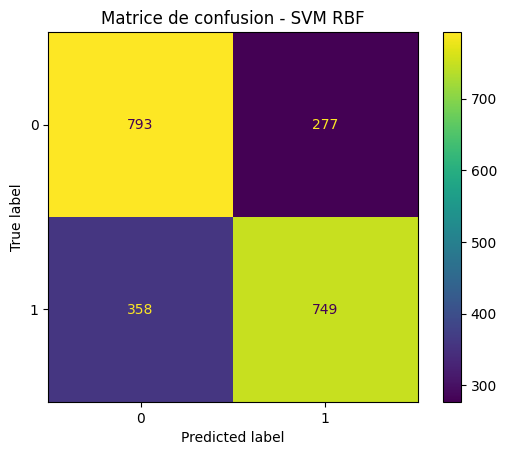

In [ ]:
# Pareil ici pour le Gini

svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf.fit(X_train_bin, y_train_bin)
evaluate_model(svm_rbf, X_test_bin, y_test_bin, "SVM RBF")

### Arbres de décisions


Arbre de décision
Accuracy : 0.6500
F1-score : 0.6497
MSE : 0.3500
AUC : 0.6505


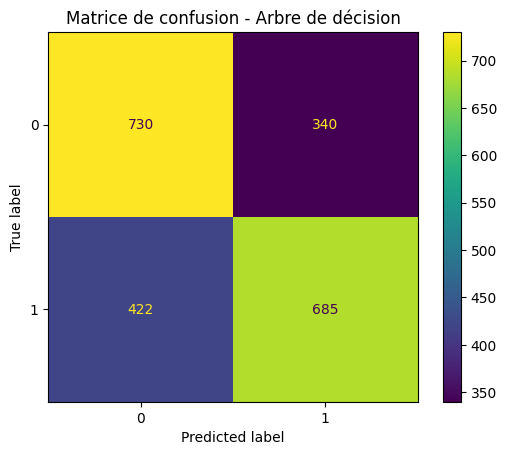

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train_bin, y_train_bin)
evaluate_model(tree, X_test_bin, y_test_bin, "Arbre de décision")


### Random Forest


Random Forest
Accuracy : 0.7644
F1-score : 0.7641
MSE : 0.2356
AUC : 0.7638


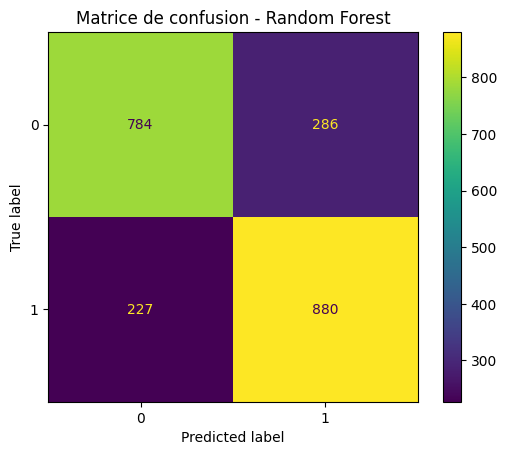

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_bin, y_train_bin)
evaluate_model(rf, X_test_bin, y_test_bin, "Random Forest")


### Bagging


Bagging
Accuracy : 0.7593
F1-score : 0.7590
MSE : 0.2407
AUC : 0.7588


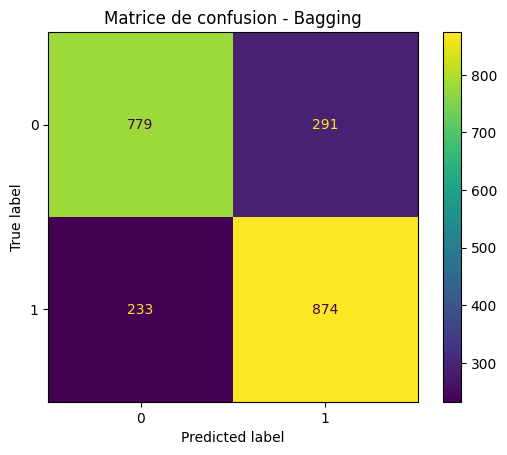

In [ ]:
bagging = BaggingClassifier(n_estimators=100)
bagging.fit(X_train_bin, y_train_bin)
evaluate_model(bagging, X_test_bin, y_test_bin, "Bagging")


### Gradient boosting


Gradient Boosting
Accuracy : 0.7703
F1-score : 0.7698
MSE : 0.2297
AUC : 0.7696


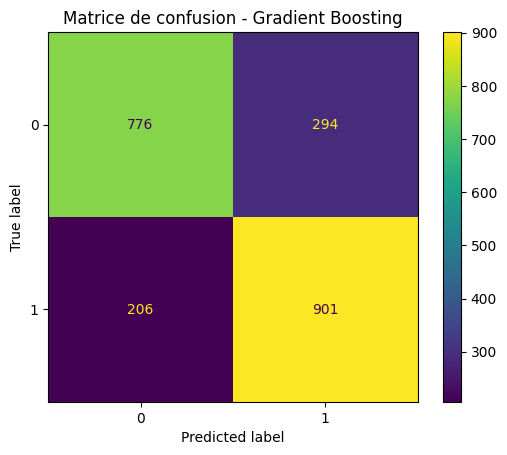

In [ ]:
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train_bin, y_train_bin)
evaluate_model(gb, X_test_bin, y_test_bin, "Gradient Boosting")


### XG-Boost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:24:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost
Accuracy : 0.7492
F1-score : 0.7491
MSE : 0.2508
AUC : 0.7489


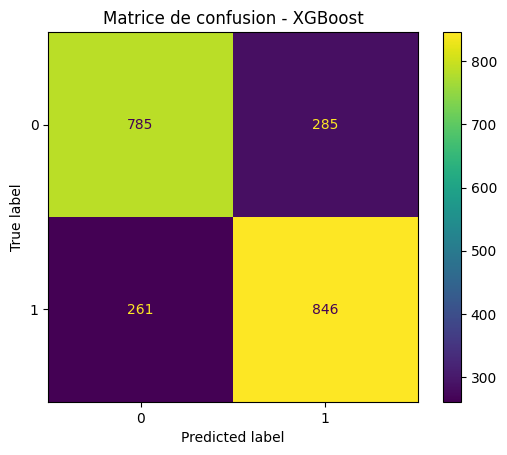

In [ ]:
# Initialisation du modèle
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Entraînement
xgb_model.fit(X_train_bin, y_train_bin)

# Évaluation avec ta fonction existante
evaluate_model(xgb_model, X_test_bin, y_test_bin, "XGBoost")


### Lightgbm

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4567, number of negative: 4494
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8443
[LightGBM] [Info] Number of data points in the train set: 9061, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504028 -> initscore=0.016113
[LightGBM] [Info] Start training from score 0.016113

LightGBM
Accuracy : 0.7703
F1-score : 0.7699
MSE : 0.2297
AUC : 0.7697


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


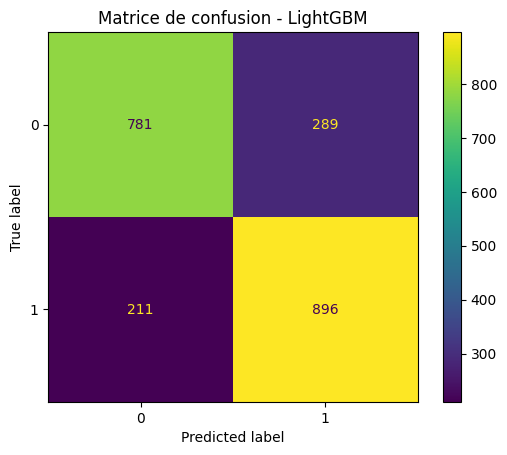

In [ ]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=42
)

lgb_model.fit(X_train_bin, y_train_bin)

evaluate_model(lgb_model, X_test_bin, y_test_bin, "LightGBM")

## Prédiction de la variable score_multi

In [ ]:
## Préparation des données

col_a_enlever = ["Score","Score_norm","com","Score_norm_reel","Score_bin","Score_multi","taux_tues","taux_indemne","taux_hospitalise","taux_blesses_legerement"]

X_train_multi = df_train.drop(columns=col_a_enlever)
X_test_multi = df_test.drop(columns=col_a_enlever)

y_train_multi = df_train["Score_multi"]
y_test_multi = df_test["Score_multi"]

# Normalisation + clipping
scaler = StandardScaler()
X_train_multi = scaler.fit_transform(X_train_multi)
X_test_multi = scaler.transform(X_test_multi)

# On a certaines valeurs manquantes, on les remplace par la moyenne
imputer = SimpleImputer(strategy='mean')
X_train_multi = imputer.fit_transform(X_train_multi)
X_test_multi = imputer.fit_transform(X_test_multi)

In [ ]:
def evaluate_model_multiclass(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    mse = mean_squared_error(y_test, y_pred)

    print(f"\n{model_name}")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-score (weighted) : {f1:.4f}")
    print(f"MSE : {mse:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Matrice de confusion - {model_name}")
    plt.show()

### Régression logistique

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Régression logistique
Accuracy : 0.5361
F1-score (weighted) : 0.5197
MSE : 0.8195


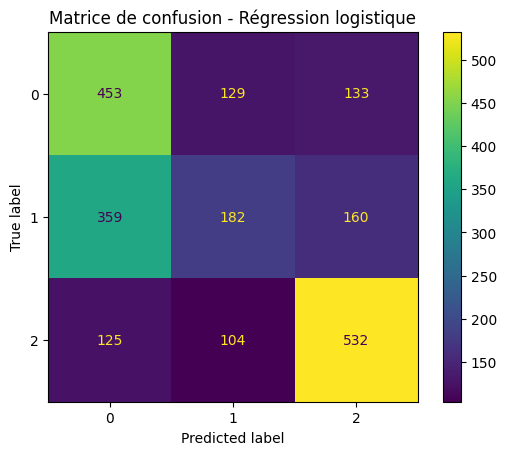

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial')
log_reg.fit(X_train_multi, y_train_multi)
evaluate_model_multiclass(log_reg, X_test_multi, y_test_multi, "Régression logistique")

### KNN


KNN
Accuracy : 0.4401
F1-score (weighted) : 0.4428
MSE : 0.9706


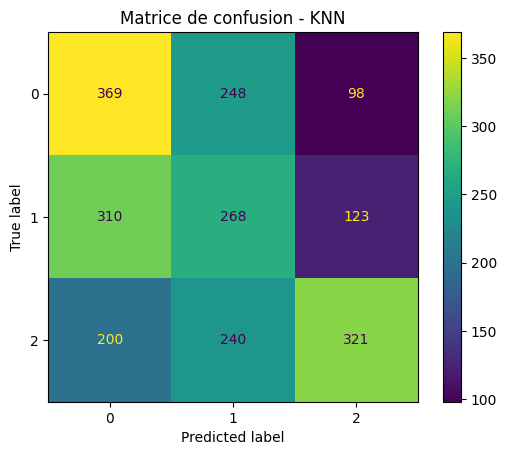

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_multi, y_train_multi)
evaluate_model_multiclass(knn, X_test_multi, y_test_multi, "KNN")

### SVM

Linéaire


SVM Linéaire
Accuracy : 0.5255
F1-score (weighted) : 0.5257
MSE : 0.7818


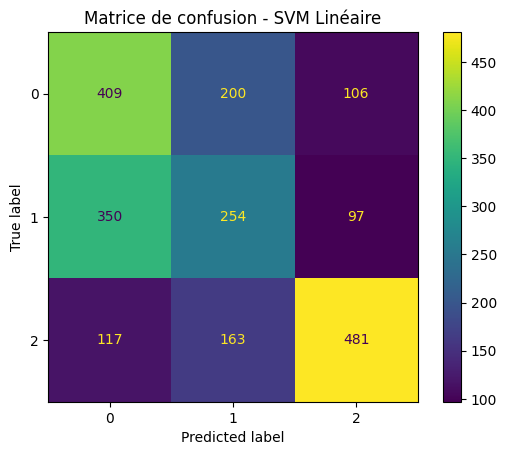

In [ ]:
# Probability = True sinon le calcul du Gini n'est pas automatique

svm_lin = SVC(kernel='linear', probability=True)
svm_lin.fit(X_train_multi, y_train_multi)
evaluate_model_multiclass(svm_lin, X_test_multi, y_test_multi, "SVM Linéaire")

Radial


SVM RBF
Accuracy : 0.5494
F1-score (weighted) : 0.5482
MSE : 0.7703


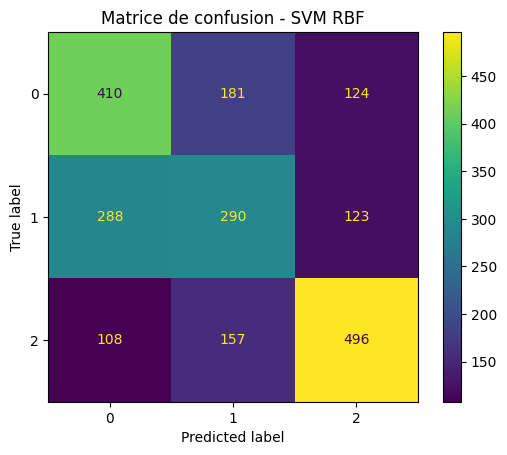

In [ ]:
# Pareil ici pour le Gini

svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf.fit(X_train_multi, y_train_multi)
evaluate_model_multiclass(svm_rbf, X_test_multi, y_test_multi, "SVM RBF")

### Arbres de décisions


Arbre de décision
Accuracy : 0.5315
F1-score (weighted) : 0.5318
MSE : 0.9136


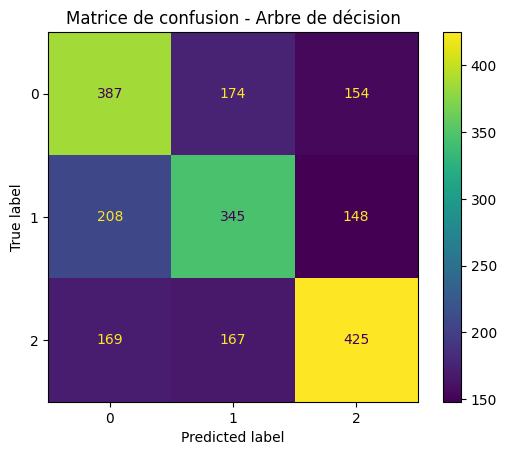

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train_multi, y_train_multi)
evaluate_model_multiclass(tree, X_test_multi, y_test_multi, "Arbre de décision")

### Random Forest


Random Forest
Accuracy : 0.6325
F1-score (weighted) : 0.6324
MSE : 0.6210


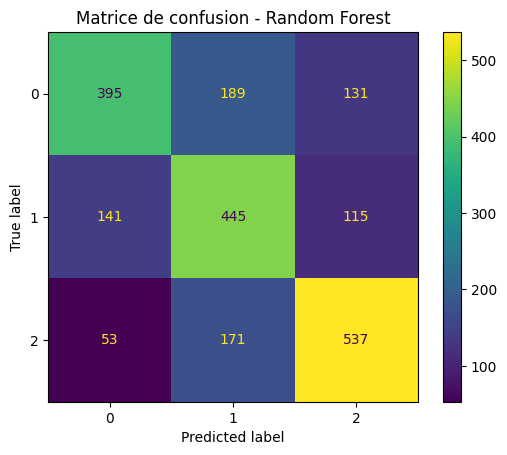

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_multi, y_train_multi)
evaluate_model_multiclass(rf, X_test_multi, y_test_multi, "Random Forest")

### Bagging


Bagging
Accuracy : 0.6261
F1-score (weighted) : 0.6264
MSE : 0.6316


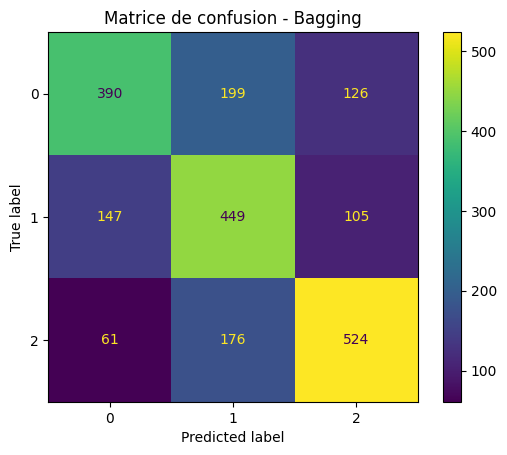

In [ ]:
bagging = BaggingClassifier(n_estimators=100)
bagging.fit(X_train_multi, y_train_multi)
evaluate_model_multiclass(bagging, X_test_multi, y_test_multi, "Bagging")

### Gradient boosting


Gradient Boosting
Accuracy : 0.6403
F1-score (weighted) : 0.6396
MSE : 0.6008


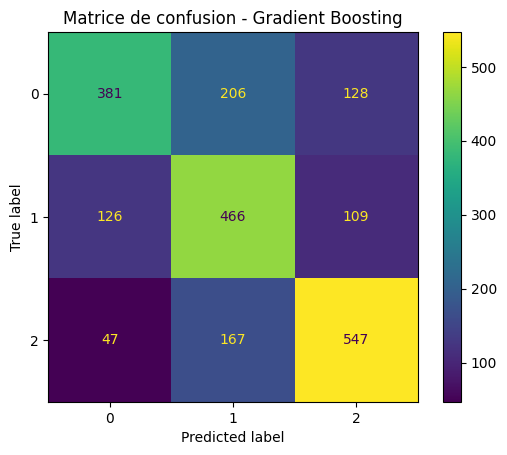

In [ ]:
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train_multi, y_train_multi)
evaluate_model_multiclass(gb, X_test_multi, y_test_multi, "Gradient Boosting")

### XG-Boost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:27:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost
Accuracy : 0.6229
F1-score (weighted) : 0.6224
MSE : 0.6500


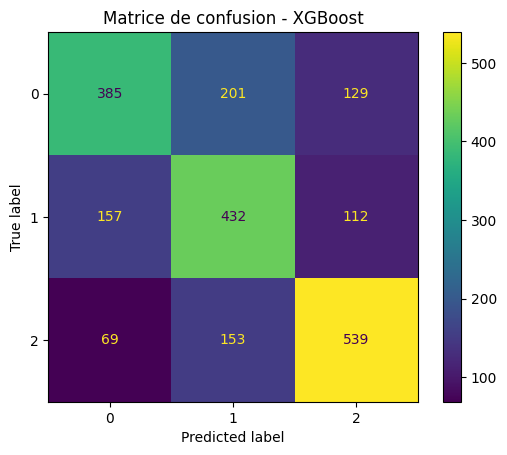

In [ ]:
# Pour XG-Boost, il attend 0,1 ou 2. On enlève donc 1 partout

# Décalage des classes pour XGBoost
y_train_xgb = y_train_multi - 1
y_test_xgb = y_test_multi - 1

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Entraînement
xgb_model.fit(X_train_multi, y_train_xgb)

# Évaluation avec ta fonction existante
evaluate_model_multiclass(xgb_model, X_test_multi, y_test_xgb, "XGBoost")

### Lightgbm

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8443
[LightGBM] [Info] Number of data points in the train set: 9061, number of used features: 45
[LightGBM] [Info] Start training from score -1.101707
[LightGBM] [Info] Start training from score -1.136170
[LightGBM] [Info] Start training from score -1.059438


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM
Accuracy : 0.6252
F1-score (weighted) : 0.6252
MSE : 0.6270


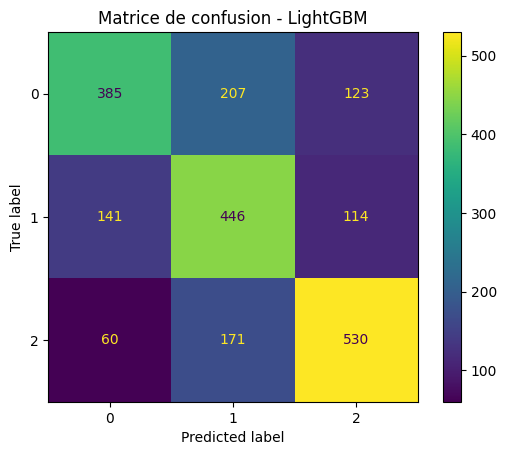

In [ ]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=42
)

lgb_model.fit(X_train_multi, y_train_multi)

evaluate_model_multiclass(lgb_model, X_test_multi, y_test_multi, "LightGBM")

# 3.1.3 - Optimisation des hyperparamètres

## Pour score_bin

### Gradient boosting avec une optimisation manuelle

Meilleur modèle : Nombre d'arbres=200, lr=0.1, depth=3, accuracy=0.7726

Meilleur Gradient Boosting (n_estimators=200, lr=0.1, depth=3)
Accuracy : 0.7726
F1-score : 0.7721
MSE : 0.2274
AUC : 0.7719


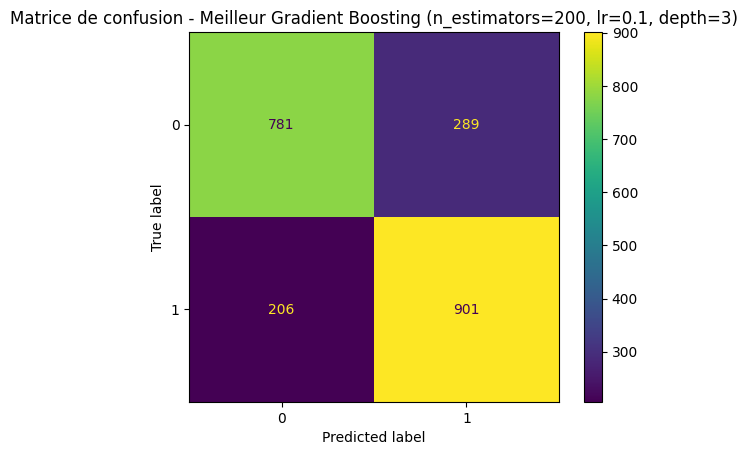

Pire modèle : n_estimators=50, lr=0.01, depth=2, accuracy=0.7556

Moins bon Gradient Boosting (n_estimators=50, lr=0.01, depth=2)
Accuracy : 0.7556
F1-score : 0.7548
MSE : 0.2444
AUC : 0.7547


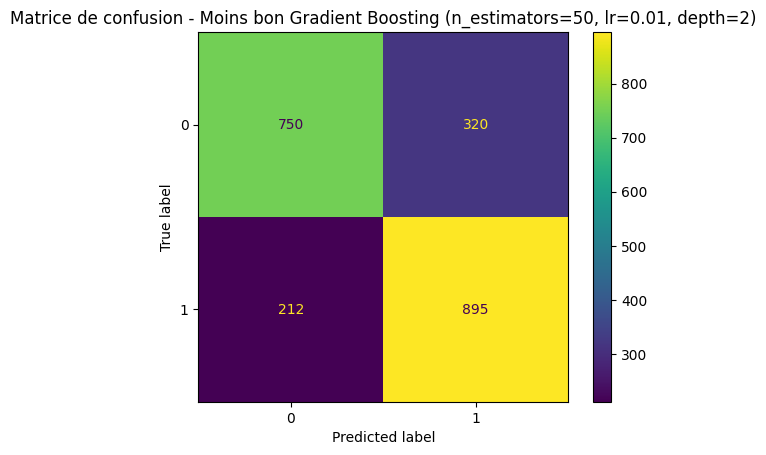

In [ ]:
# Hyperparamètres
liste_nb_arbres = [50, 100, 200]
liste_learning_rate = [0.01, 0.05, 0.1]
liste_profondeur_arbres = [2, 3, 5]

# Stocker les résultats
results = []

for n_estimators in liste_nb_arbres:
    for learning_rate in liste_learning_rate:
        for max_depth in liste_profondeur_arbres:
            gb = GradientBoostingClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42
            )
            gb.fit(X_train_bin, y_train_bin)
            y_pred = gb.predict(X_test_bin)
            acc = accuracy_score(y_test_bin, y_pred)
            f1 = f1_score(y_test_bin, y_pred)
            mse = mean_squared_error(y_test_bin, y_pred)
            gini = 2 * roc_auc_score(y_test_bin, y_pred) - 1

            results.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'accuracy': acc,
                'f1': f1,
                'gini': gini,
                'mse' : mse
            })

# Trouver le meilleur et le pire modèle en fonction de l'accuracy
best = max(results, key=lambda x: (
    (x['accuracy'] + x['f1'] + x['gini'] + (1 - x['mse'])) / 4
))
worst = min(results, key=lambda x: (
    (x['accuracy'] + x['f1'] + x['gini'] + (1 - x['mse'])) / 4
))

gb_best = GradientBoostingClassifier(
                n_estimators=best['n_estimators'],
                learning_rate=best['learning_rate'],
                max_depth=best['max_depth'],
                random_state=42
            )
gb_best.fit(X_train_bin, y_train_bin)

print(f"Meilleur modèle : Nombre d'arbres={best['n_estimators']}, lr={best['learning_rate']}, depth={best['max_depth']}, accuracy={best['accuracy']:.4f}")
evaluate_model(gb_best, X_test_bin, y_test_bin, f"Meilleur Gradient Boosting (n_estimators={best['n_estimators']}, lr={best['learning_rate']}, depth={best['max_depth']})")

gb_worst = GradientBoostingClassifier(
                n_estimators=worst['n_estimators'],
                learning_rate=worst['learning_rate'],
                max_depth=worst['max_depth'],
                random_state=42
            )
gb_worst.fit(X_train_bin, y_train_bin)

print(f"Pire modèle : n_estimators={worst['n_estimators']}, lr={worst['learning_rate']}, depth={worst['max_depth']}, accuracy={worst['accuracy']:.4f}")
evaluate_model(gb_worst, X_test_bin, y_test_bin, f"Moins bon Gradient Boosting (n_estimators={worst['n_estimators']}, lr={worst['learning_rate']}, depth={worst['max_depth']})")

### Arbres de décision avec GridSearchCV


Best tree parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best tree score (cv): 0.7617284536868264

Decision Tree (GridSearchCV)
Accuracy : 0.7515
F1-score : 0.7509
MSE : 0.2485
AUC : 0.7507


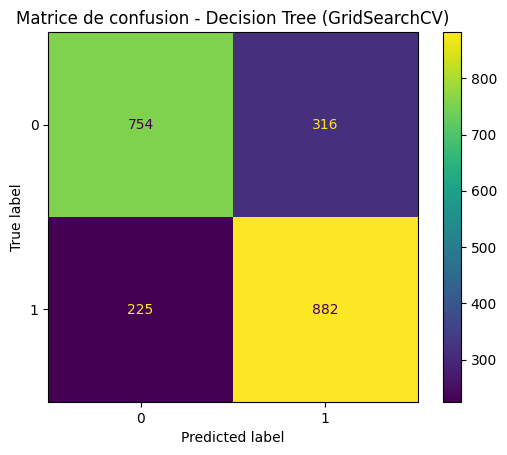

In [ ]:
param_grid_dt = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy', 'log_loss']
}

# Instanciation du modèle
dt = DecisionTreeClassifier(random_state=42)

# Configuration de la recherche de grille
grid_search_dt = GridSearchCV(
    dt,
    param_grid_dt,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Entraînement sur les données binaires
grid_search_dt.fit(X_train_bin, y_train_bin)

# Affichage des meilleurs paramètres et du meilleur score cross‐validation
print("Best tree parameters:", grid_search_dt.best_params_)
print("Best tree score (cv):", grid_search_dt.best_score_)

# Évaluation sur le jeu de test binaire
best_dt_bin = grid_search_dt.best_estimator_
evaluate_model(best_dt_bin, X_test_bin, y_test_bin, "Decision Tree (GridSearchCV)")

Worst tree parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Worst tree score (cv)  : 0.6652723949791121

Decision Tree (Worst GridSearchCV model)
Accuracy : 0.6481
F1-score : 0.6481
MSE : 0.3519
AUC : 0.6483


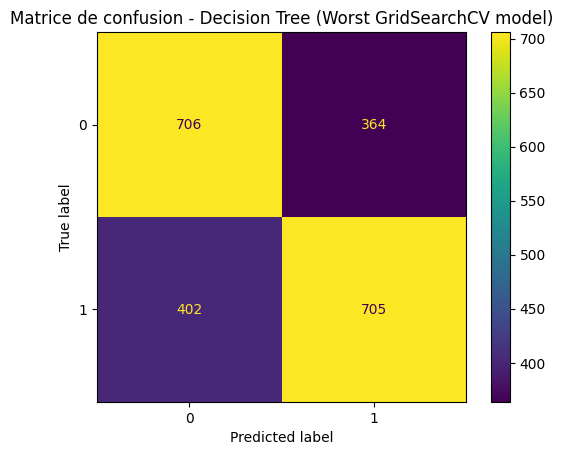

In [ ]:
# Récupération du moins bon modèle d'arbres de décisions
scores = grid_search_dt.cv_results_['mean_test_score']
params = grid_search_dt.cv_results_['params']

# trouver l’indice du plus petit score (le « pire » modèle)
worst_idx = np.argmin(scores)
worst_params = params[worst_idx]
worst_score = scores[worst_idx]

print("Worst tree parameters:", worst_params)
print("Worst tree score (cv)  :", worst_score)

# re-création et entraînement du modèle « pire »
worst_dt_bin = DecisionTreeClassifier(random_state=42, **worst_params)
worst_dt_bin.fit(X_train_bin, y_train_bin)

# évaluation sur le jeu de test
evaluate_model(
    worst_dt_bin,
    X_test_bin,
    y_test_bin,
    "Decision Tree (Worst GridSearchCV model)"
)

### KNN avec RandomSearchCV

Meilleurs paramètres trouvés : {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}
Meilleur score (cv)         : 0.6766380044052702

KNN (RandomizedSearchCV)
Accuracy : 0.6803
F1-score : 0.6802
MSE : 0.3197
AUC : 0.6807


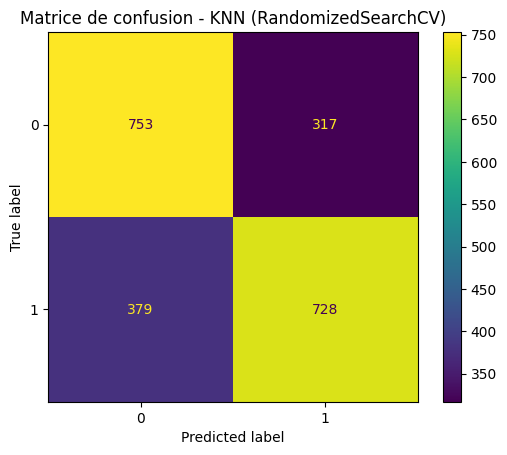

In [ ]:
param_dist = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan','minkowski']
}

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist,
    n_iter=10,               # on teste 10 combinaisons aléatoires
    cv=5,                    # 5-fold cross-validation
    scoring='accuracy',      # métrique à optimiser
    n_jobs=-1,
    random_state=42
)

# Entraînement sur les données binaires
random_search.fit(X_train_bin, y_train_bin)

# Restitution des meilleurs paramètres et score CV
print("Meilleurs paramètres trouvés :", random_search.best_params_)
print("Meilleur score (cv)         :", random_search.best_score_)

# Évaluation sur le jeu de test binaire
best_knn_bin = random_search.best_estimator_
evaluate_model(
    best_knn_bin,
    X_test_bin,
    y_test_bin,
    "KNN (RandomizedSearchCV)"
)


Pires paramètres trouvés : {'weights': 'uniform', 'n_neighbors': 3, 'metric': 'minkowski'}
Pire score (cv)          : 0.6143911582889824

KNN (Worst RandomizedSearchCV model)
Accuracy : 0.6073
F1-score : 0.6073
MSE : 0.3927
AUC : 0.6073


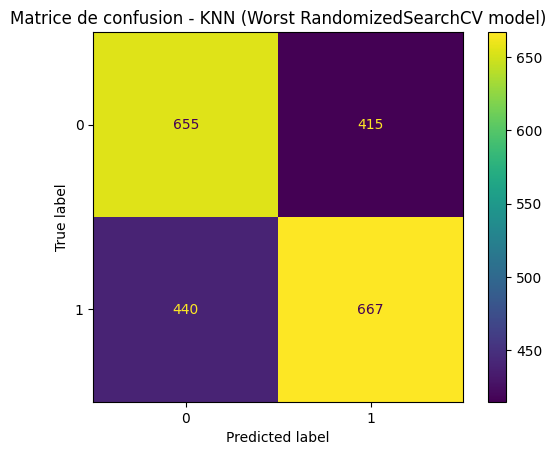

In [ ]:
results = random_search.cv_results_
scores = results['mean_test_score']
params = results['params']

# Trouver l’indice du pire score (modèle « worst »)
worst_idx = np.argmin(scores)
worst_params = params[worst_idx]
worst_score = scores[worst_idx]

print("Pires paramètres trouvés :", worst_params)
print("Pire score (cv)          :", worst_score)

# Reconstruire et entraîner le modèle « pire »
worst_knn_bin = KNeighborsClassifier(**worst_params)
worst_knn_bin.fit(X_train_bin, y_train_bin)

# Évaluer sur le jeu de test binaire
evaluate_model(
    worst_knn_bin,
    X_test_bin,
    y_test_bin,
    "KNN (Worst RandomizedSearchCV model)"
)

## Pour Score_multi

### Gradient boosting avec une optimisation manuelle

Meilleur modèle : Nombre d'arbres=100, lr=0.1, depth=3, accuracy=0.6399

Gradient Boosting BEST (n_estimators=100, lr=0.1, depth=3)
Accuracy : 0.6399
F1-score (weighted) : 0.6391
MSE : 0.6027


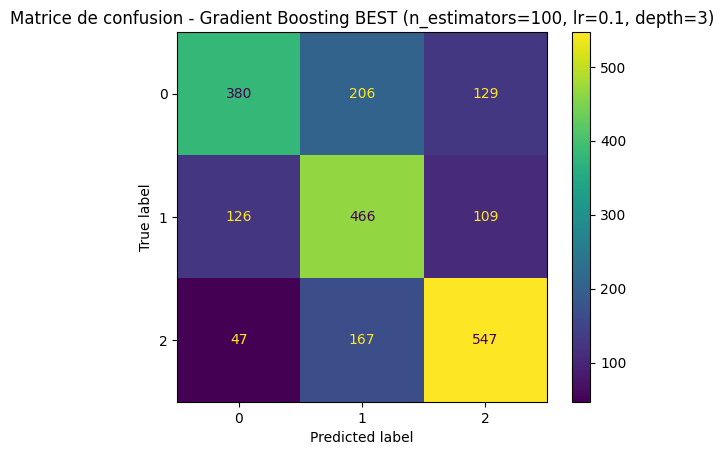

Pire modèle : n_estimators=100, lr=0.01, depth=2, accuracy=0.6022

Gradient Boosting WORST (n_estimators=100, lr=0.01, depth=2)
Accuracy : 0.6022
F1-score (weighted) : 0.6000
MSE : 0.6307


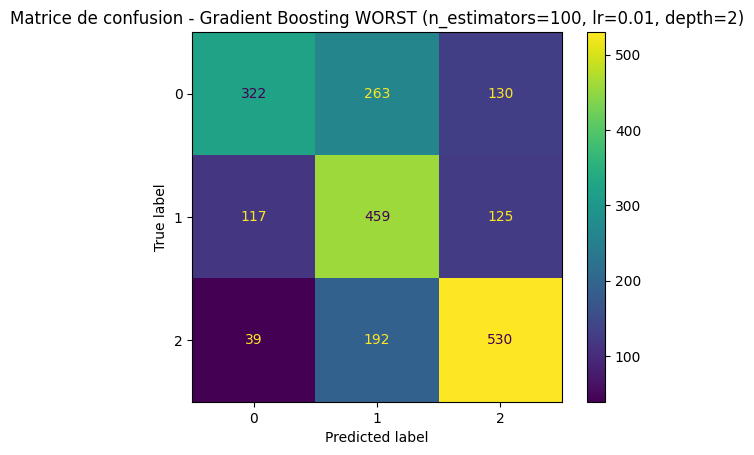

In [ ]:
# Hyperparamètres
liste_nb_arbres = [50, 100, 200]
liste_learning_rate = [0.01, 0.05, 0.1]
liste_profondeur_arbres = [2, 3, 5]

results = []

for n_estimators in liste_nb_arbres:
    for learning_rate in liste_learning_rate:
        for max_depth in liste_profondeur_arbres:
            gb = GradientBoostingClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42
            )
            gb.fit(X_train_multi, y_train_multi)
            y_pred = gb.predict(X_test_multi)
            acc = accuracy_score(y_test_multi, y_pred)
            f1 = f1_score(y_test_multi, y_pred, average='weighted')
            mse = mean_squared_error(y_test_multi, y_pred)

            results.append({
                'model': gb,
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'accuracy': acc,
                'f1': f1,
                'mse': mse
            })

# Trouver le meilleur et le pire modèle en fonction de l'accuracy
best = max(results, key=lambda x: (
    (x['accuracy'] + x['f1'] + (1 - x['mse'])) / 3
))
worst = min(results, key=lambda x: (
    (x['accuracy'] + x['f1'] + (1 - x['mse'])) / 3
))

print(f"Meilleur modèle : Nombre d'arbres={best['n_estimators']}, lr={best['learning_rate']}, depth={best['max_depth']}, accuracy={best['accuracy']:.4f}")
evaluate_model_multiclass(best['model'], X_test_multi, y_test_multi, f"Gradient Boosting BEST (n_estimators={best['n_estimators']}, lr={best['learning_rate']}, depth={best['max_depth']})")

print(f"Pire modèle : n_estimators={worst['n_estimators']}, lr={worst['learning_rate']}, depth={worst['max_depth']}, accuracy={worst['accuracy']:.4f}")
evaluate_model_multiclass(worst['model'], X_test_multi, y_test_multi, f"Gradient Boosting WORST (n_estimators={worst['n_estimators']}, lr={worst['learning_rate']}, depth={worst['max_depth']})")

### Arbres de décision avec gridsearchCV


Best tree parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best tree score (cv): 0.6258720742637489

Decision Tree (GridSearchCV)
Accuracy : 0.6160
F1-score (weighted) : 0.6162
MSE : 0.6238


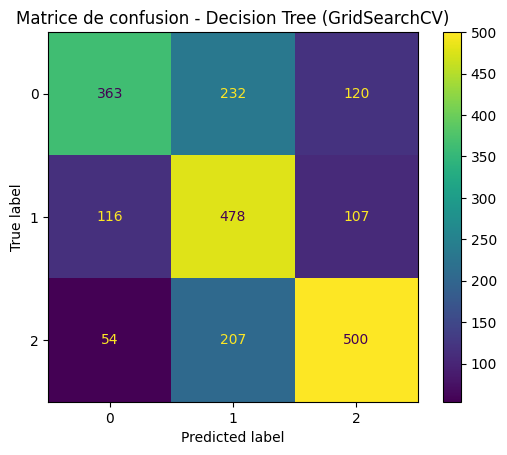

In [ ]:
param_grid_dt = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy', 'log_loss']
}

dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(
    dt,
    param_grid_dt,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_dt.fit(X_train_multi, y_train_multi)

best_params = grid_search_dt.best_params_

print("Best tree parameters:", best_params)
print("Best tree score (cv):", grid_search_dt.best_score_)

best_tree = grid_search_dt.best_estimator_
evaluate_model_multiclass(best_tree, X_test_multi, y_test_multi, "Decision Tree (GridSearchCV)")


Worst tree parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Worst tree score (cv)  : 0.5198106269534841

Decision Tree (Worst GridSearchCV model)
Accuracy : 0.5158
F1-score (weighted) : 0.5165
MSE : 0.9017


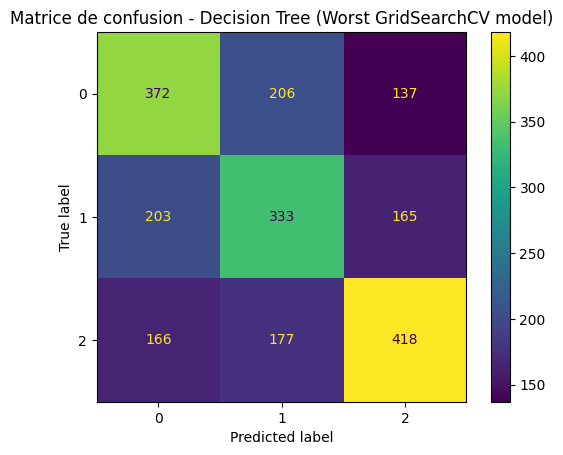

In [ ]:
# Récupération du moins bon modèle d'arbres de décisions
scores = grid_search_dt.cv_results_['mean_test_score']
params = grid_search_dt.cv_results_['params']

# trouver l’indice du plus petit score (le « pire » modèle)
worst_idx = np.argmin(scores)
worst_params = params[worst_idx]
worst_score = scores[worst_idx]

print("Worst tree parameters:", worst_params)
print("Worst tree score (cv)  :", worst_score)

# re-création et entraînement du modèle « pire »
worst_dt_multi = DecisionTreeClassifier(random_state=42, **worst_params)
worst_dt_multi.fit(X_train_multi, y_train_multi)

# évaluation sur le jeu de test
evaluate_model_multiclass(
    worst_dt_multi,
    X_test_multi,
    y_test_multi,
    "Decision Tree (Worst GridSearchCV model)"
)

### KNN avec RandomSearchCV

Meilleurs paramètres trouvés : {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}
Meilleur score (cv)         : 0.5054639109984427

KNN (RandomizedSearchCV)
Accuracy : 0.5094
F1-score (weighted) : 0.5103
MSE : 0.8379


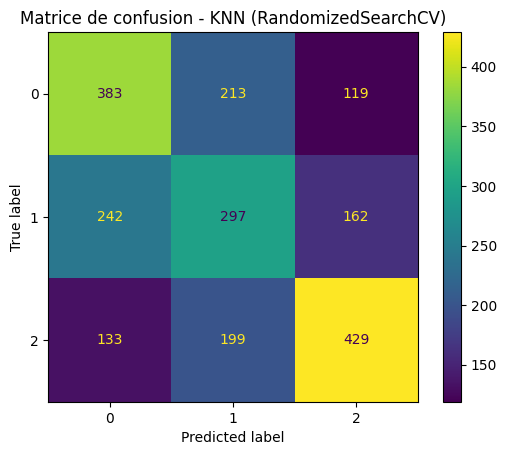

In [ ]:
param_list = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan','minkowski']
}

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_list,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# entraînement
random_search.fit(X_train_multi, y_train_multi)

# restitution des meilleurs paramètres et score CV
print("Meilleurs paramètres trouvés :", random_search.best_params_)
print("Meilleur score (cv)         :", random_search.best_score_)

# évaluation sur le jeu de test
best_knn = random_search.best_estimator_
evaluate_model_multiclass(
    best_knn,
    X_test_multi,
    y_test_multi,
    "KNN (RandomizedSearchCV)"
)

Pires paramètres trouvés : {'weights': 'uniform', 'n_neighbors': 3, 'metric': 'minkowski'}
Pire score (cv)          : 0.44222344387907303

KNN (Worst RandomizedSearchCV model)
Accuracy : 0.4364
F1-score (weighted) : 0.4359
MSE : 1.0459


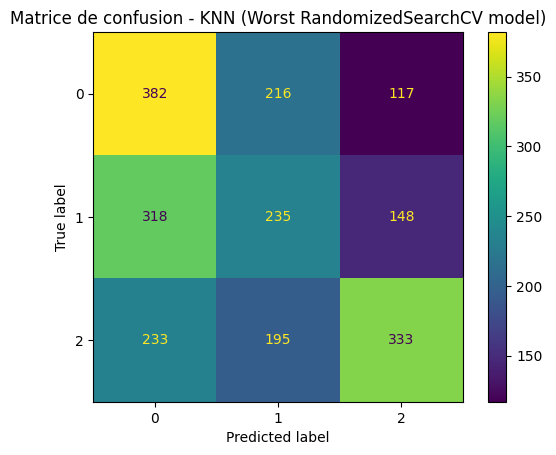

In [ ]:
results = random_search.cv_results_
scores = results['mean_test_score']
params = results['params']

# Trouver l’indice du pire score (modèle « worst »)
worst_idx = np.argmin(scores)
worst_params = params[worst_idx]
worst_score = scores[worst_idx]

print("Pires paramètres trouvés :", worst_params)
print("Pire score (cv)          :", worst_score)

# Reconstruire et entraîner le modèle « pire »
worst_knn_multi = KNeighborsClassifier(**worst_params)
worst_knn_multi.fit(X_train_multi, y_train_multi)

# Évaluer sur le jeu de test binaire
evaluate_model_multiclass(
    worst_knn_multi,
    X_test_multi,
    y_test_multi,
    "KNN (Worst RandomizedSearchCV model)"
)

# Méthodes de Shap et eli5 pour déterminer l'importance des variables

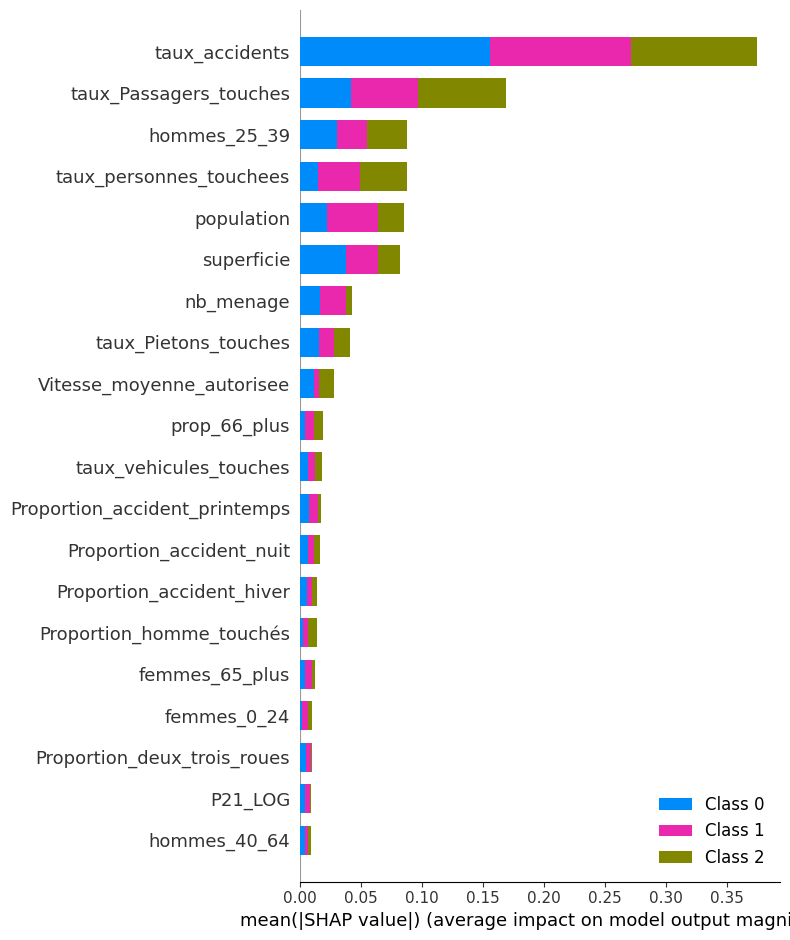

In [ ]:
explainer = shap.Explainer(best_tree, X_train_multi)
shap_values = explainer(X_test_multi)

shap.summary_plot(shap_values, X_test_multi, feature_names=df_train.drop(columns=col_a_enlever).columns)

In [ ]:
perm = PermutationImportance(best_dt_bin, random_state=42)
perm.fit(X_test_bin, y_test_bin)

eli5.show_weights(perm, feature_names=list(df_train.drop(columns=col_a_enlever).columns))

Weight,Feature
0.1722 ± 0.0198,taux_accidents
0.0504 ± 0.0025,taux_Passagers_touches
0.0181 ± 0.0086,population
0.0093 ± 0.0029,taux_Pietons_touches
0.0035 ± 0.0050,superficie
0.0023 ± 0.0027,femmes_0_24
0.0017 ± 0.0041,hommes_40_64
0.0016 ± 0.0012,taux_vehicules_touches
0.0015 ± 0.0018,Proportion_homme_touchés
0.0015 ± 0.0014,Proportion_accident_23_6


In [ ]:
perm = PermutationImportance(best_tree, random_state=42)
perm.fit(X_test_multi, y_test_multi)

eli5.show_weights(perm, feature_names=list(df_train.drop(columns=col_a_enlever).columns))

Weight,Feature
0.1805 ± 0.0062,taux_accidents
0.0684 ± 0.0121,taux_Passagers_touches
0.0362 ± 0.0084,hommes_25_39
0.0217 ± 0.0017,taux_personnes_touchees
0.0165 ± 0.0053,population
0.0120 ± 0.0036,taux_Pietons_touches
0.0093 ± 0.0077,superficie
0.0046 ± 0.0012,Vitesse_moyenne_autorisee
0.0037 ± 0.0008,prop_66_plus
0.0032 ± 0.0031,Proportion_homme_touchés


# Sélection des variables les plus pertinentes pour le modèle

In [ ]:
from sklearn.feature_selection import RFE
selector = RFE(estimator=best_tree, n_features_to_select=10)
selector.fit(X_train_multi, y_train_multi)

feature_names = df_train.drop(columns=col_a_enlever).columns

selected_mask = selector.support_
selected_features = feature_names[selected_mask]
print("Variables sélectionnées :", list(selected_features))


Variables sélectionnées : ['population', 'superficie', 'nb_menage', 'hommes_25_39', 'hommes_40_64', 'taux_accidents', 'taux_vehicules_touches', 'taux_personnes_touchees', 'taux_Pietons_touches', 'taux_Passagers_touches']



Decision Tree (après sélection RFE)
Accuracy : 0.6215
F1-score (weighted) : 0.6207
MSE : 0.6431


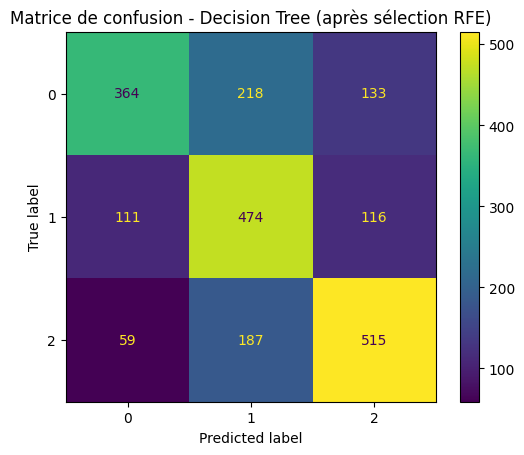

In [ ]:
# Réduire X_train_multi et X_test_multi aux variables sélectionnées
X_train_selected = X_train_multi[:, selected_mask]
X_test_selected = X_test_multi[:, selected_mask]

# Réentraîner un nouveau modèle DecisionTree sur ces variables
from sklearn.tree import DecisionTreeClassifier

refit_tree = DecisionTreeClassifier(**best_params)
refit_tree.fit(X_train_selected, y_train_multi)

# Évaluer le modèle réduit
evaluate_model_multiclass(refit_tree, X_test_selected, y_test_multi, "Decision Tree (après sélection RFE)")

In [ ]:
from sklearn.feature_selection import RFE
selector = RFE(estimator=best_tree, n_features_to_select=8)
selector.fit(X_train_multi, y_train_multi)

feature_names = df_train.drop(columns=col_a_enlever).columns

selected_mask = selector.support_
selected_features = feature_names[selected_mask]
print("Variables sélectionnées :", list(selected_features))


Variables sélectionnées : ['population', 'superficie', 'hommes_25_39', 'taux_accidents', 'taux_vehicules_touches', 'taux_personnes_touchees', 'taux_Pietons_touches', 'taux_Passagers_touches']



Decision Tree (après sélection RFE)
Accuracy : 0.6220
F1-score (weighted) : 0.6213
MSE : 0.6385


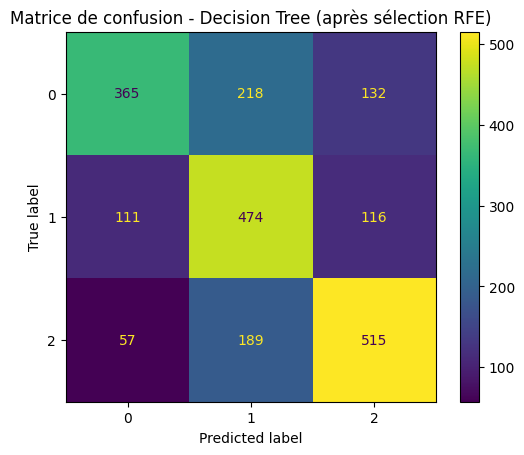

In [ ]:
# Réduire X_train_multi et X_test_multi aux variables sélectionnées
X_train_selected = X_train_multi[:, selected_mask]
X_test_selected = X_test_multi[:, selected_mask]

# Réentraîner un nouveau modèle DecisionTree sur ces variables
from sklearn.tree import DecisionTreeClassifier

refit_tree = DecisionTreeClassifier(**best_params)
refit_tree.fit(X_train_selected, y_train_multi)

# Évaluer le modèle réduit
evaluate_model_multiclass(refit_tree, X_test_selected, y_test_multi, "Decision Tree (après sélection RFE)")

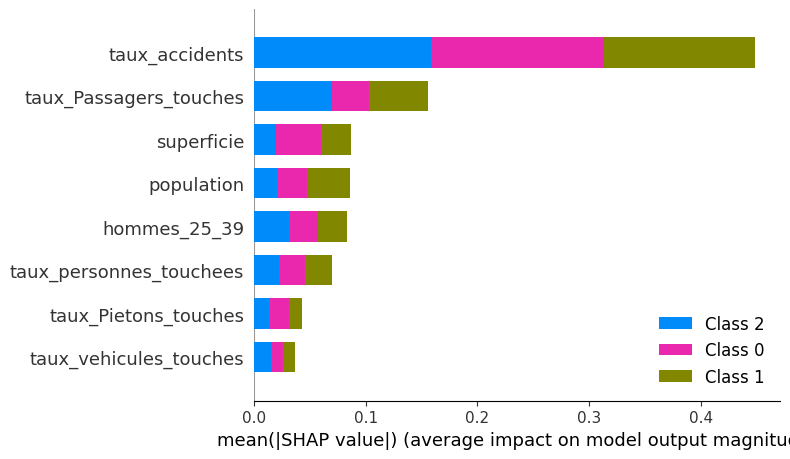

In [ ]:
explainer = shap.TreeExplainer(refit_tree)

shap_vals = explainer.shap_values(X_test_selected)

shap.summary_plot(
    shap_vals,
    X_test_selected,
    feature_names=selected_features,
    plot_type="bar"
)

## Sélection des variables via SelectFromModel

In [ ]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(best_tree, threshold='mean')
selector.fit(X_train_multi, y_train_multi)

feature_names = df_train.drop(columns=col_a_enlever).columns

selected_mask = selector.get_support()
selected_features = feature_names[selected_mask]
print("Variables sélectionnées :", list(selected_features))


Variables sélectionnées : ['population', 'superficie', 'hommes_25_39', 'taux_accidents', 'taux_Pietons_touches', 'taux_Passagers_touches']


# Application aux données réelles

CM d'un accident automobile :

Faire deux modèles : 1 binaire et 1 multi

On peut partir du principe que notre S/P actuel est de 70 %, et voir son amélioration si on ajuste notre prime

On peut aussi partir du principe que notre S/P cible est de 70 %

In [ ]:
df_global = pd.concat([df_train, df_test], axis=0, ignore_index=True).drop(columns=['Score', 'Score_norm', 'Score_norm_reel', 'Score_bin', 'taux_tues', 'taux_indemne', 'taux_hospitalise', 'taux_blesses_legerement'])

In [ ]:
delta = [-0.10, 0.02, 0.10]   # amplitude bonus–malus
P0 = 100.0     # prime de base
SP = 0.7
nb_assures = 100000
montant_sin = SP * nb_assures * P0

total_pop = df_global['population'].sum()
df_global['nb_assures'] = np.round(df_global['population'] / total_pop * nb_assures,0)

nb_actuel_assures = int(df_global['nb_assures'].sum())

indices = np.random.choice(df_global.index, size=nb_assures - nb_actuel_assures, replace=True)
df_global.loc[indices, 'nb_assures'] += 1

col_to_keep = [
    'taux_accidents',
    'taux_Passagers_touches',
    'superficie',
    'population',
    'hommes_25_39',
    'taux_personnes_touchees',
    'taux_Pietons_touches',
    'taux_vehicules_touches'
]

X = df_global[col_to_keep]
y = df_global['Score_multi']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

best_params = {'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

refit_tree = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42,
    criterion=best_params['criterion'],
    min_samples_split=best_params['min_samples_split'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf']
)

refit_tree.fit(X_train, y_train)

y_pred = refit_tree.predict(X_test)

proba = refit_tree.predict_proba(X)
classes = refit_tree.classes_

for idx, cls in enumerate(classes):
    df_global[f'proba_multi_{cls}'] = proba[:, idx]

print(df_global[['com', 'Score_multi'] + [f'proba_multi_{c}' for c in classes]].head())

     com  Score_multi  proba_multi_1  proba_multi_2  proba_multi_3
0  01001            3       0.162842       0.264646       0.572511
1  01004            2       0.728447       0.241229       0.030324
2  01010            2       0.235254       0.549830       0.214917
3  01014            1       0.456132       0.399689       0.144179
4  01015            2       0.286877       0.179784       0.533338


In [ ]:
modele_1 = df_global

modele_1['Delta_i'] = (
    modele_1['proba_multi_1'] * delta[0] +
    modele_1['proba_multi_2'] * delta[1] +
    modele_1['proba_multi_3'] * delta[2]
)

modele_1['prime_ajustee'] = P0 * (1 + modele_1['Delta_i'])

modele_1['prime_totale_commune'] = modele_1['nb_assures'] * modele_1['prime_ajustee']


prime_nationale = modele_1['prime_totale_commune'].sum()
nouveau_SP = montant_sin / prime_nationale

print(f"Prime nationale totale : {prime_nationale:.2f} €")
print(f"Nouveau ratio S/P : {nouveau_SP:.3f}")

Prime nationale totale : 9677630.50 €
Nouveau ratio S/P : 0.723


In [ ]:
modele_2 = df_global

modele_2['Zonier'] = np.select(
    [
        (modele_2['proba_multi_1'] > modele_2['proba_multi_2']) &
        (modele_2['proba_multi_1'] > modele_2['proba_multi_3']),

        (modele_2['proba_multi_2'] > modele_2['proba_multi_1']) &
        (modele_2['proba_multi_2'] > modele_2['proba_multi_3'])
    ],
    [1, 2],
    default=3
)

modele_2['Delta_zone'] = np.where(
    modele_2['Zonier'] == 1, -0.10,
    np.where(modele_2['Zonier'] == 2, 0.02, 0.10)
)
modele_2['prime_ajustee'] = P0 * (1 + modele_2['Delta_zone'])

modele_2['prime_totale_commune'] = modele_2['nb_assures'] * modele_2['prime_ajustee']

prime_nationale = modele_2['prime_totale_commune'].sum()
nouveau_SP = montant_sin / prime_nationale

print(f"Prime nationale totale : {prime_nationale:.2f} €")
print(f"Nouveau ratio S/P : {nouveau_SP:.3f}")

Prime nationale totale : 9565882.00 €
Nouveau ratio S/P : 0.732


In [ ]:
matches = df_global['Score_multi'] == df_global['Zonier']

taux_ressemblance = matches.mean()

print(f"Taux de ressemblance : {taux_ressemblance:.2%} ({matches.sum()} concordances sur {len(df_global)})")

## On observe que cela coincide avec le score de notre modèle. On peut donc continuer

Taux de ressemblance : 63.45% (7130 concordances sur 11238)


In [ ]:
modele_3 = df_global.copy()

delta_values = [-0.10, 0.2, 0.10]

p1 = modele_3['proba_multi_1']
p2 = modele_3['proba_multi_2']
p3 = modele_3['proba_multi_3']

# Calcul par défaut : moyenne pondérée des trois
delta_final = p1 * delta_values[0] + p2 * delta_values[1] + p3 * delta_values[2]

# Mask si p1 et p2 proches
mask_12 = (abs(p1 - p2) <= 0.05) & (p1 > p3) & (p2 > p3)
delta_final[mask_12] = p1[mask_12] * delta_values[0] + p2[mask_12] * delta_values[1]

# Mask si p2 et p3 proches
mask_23 = (abs(p2 - p3) <= 0.05) & (p2 > p1) & (p3 > p1)
delta_final[mask_23] = p2[mask_23] * delta_values[1] + p3[mask_23] * delta_values[2]

# Mask si p1 et p3 proches
mask_13 = (abs(p1 - p3) <= 0.05) & (p1 > p2) & (p3 > p2)
delta_final[mask_13] = p1[mask_13] * delta_values[0] + p3[mask_13] * delta_values[2]

# Appliquer au DataFrame
modele_3['Delta_zone'] = delta_final
modele_3['prime_ajustee'] = P0 * (1 + modele_3['Delta_zone'])
modele_3['prime_totale_commune'] = modele_3['nb_assures'] * modele_3['prime_ajustee']

# Résultat final
prime_nationale = modele_3['prime_totale_commune'].sum()
nouveau_SP = montant_sin / prime_nationale

print(f"Prime nationale totale (modèle 3, vectorisé avec incertitude) : {prime_nationale:.2f} €")
print(f"Nouveau ratio S/P (modèle 3, vectorisé avec incertitude) : {nouveau_SP:.3f}")

Prime nationale totale (modèle 3, vectorisé avec incertitude) : 10400292.41 €
Nouveau ratio S/P (modèle 3, vectorisé avec incertitude) : 0.673
